In [2]:
!pip install holidays

In [3]:
from itertools import combinations
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_absolute_error as mae  
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from xgboost import XGBRegressor
import holidays
import plotly.io as pio

In [4]:
data = pd.read_csv('/kaggle/input/mastercard-stock-data-latest-and-updated/Mastercard_stock_history.csv')
data.sample(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
2623,2016-10-25,100.276717,100.325301,99.402124,99.975464,4869300,0.0,0.0
3332,2019-08-21,276.447225,278.879130,276.101216,278.790161,2492200,0.0,0.0
1634,2012-11-20,45.420964,45.755661,44.773381,45.280640,6804000,0.0,0.0
2758,2017-05-10,113.288118,113.932074,113.190550,113.814995,1812500,0.0,0.0
1907,2013-12-20,76.940935,78.335964,76.797244,77.749786,13154000,0.0,0.0


# Análise de estátisticas - (DATA UNDERSTANDING)
* 1. Estátisticas básicas
* 2. Campos nulos
* 3. Dimensão
* 4. Correlação entre os dados


## Tipo de dado e amostra

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3872 entries, 0 to 3871
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3872 non-null   object 
 1   Open          3872 non-null   float64
 2   High          3872 non-null   float64
 3   Low           3872 non-null   float64
 4   Close         3872 non-null   float64
 5   Volume        3872 non-null   int64  
 6   Dividends     3872 non-null   float64
 7   Stock Splits  3872 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 242.1+ KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,3872.0,1.048968e+02,1.062455e+02,3.748967,2.234720e+01,7.081008e+01,1.476884e+02,3.926539e+02
High,3872.0,1.059561e+02,1.073036e+02,4.102467,2.263800e+01,7.137590e+01,1.486454e+02,4.005215e+02
Low,3872.0,1.037693e+02,1.050501e+02,3.739664,2.203446e+01,7.022400e+01,1.468220e+02,3.897478e+02
Close,3872.0,1.048827e+02,1.061687e+02,4.083861,2.230039e+01,7.085608e+01,1.476884e+02,3.946857e+02
Volume,3872.0,1.232250e+07,1.759665e+07,641100.000000,3.529475e+06,5.891750e+06,1.319775e+07,3.953430e+08
Dividends,3872.0,2.329029e-03,2.585085e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e-01
Stock Splits,3872.0,2.582645e-03,1.607061e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01


## Dados em falta

In [7]:
data.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [8]:
data.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

## Definir data como INDEX

In [9]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

#data = data.asfreq('D')
data = data.dropna()
# Verificando a frequência
print(data.index.freq)

None


In [10]:
data.index

DatetimeIndex(['2006-05-25', '2006-05-26', '2006-05-30', '2006-05-31',
               '2006-06-01', '2006-06-02', '2006-06-05', '2006-06-06',
               '2006-06-07', '2006-06-08',
               ...
               '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01',
               '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
               '2021-10-08', '2021-10-11'],
              dtype='datetime64[ns]', name='Date', length=3872, freq=None)

## Dimensionalidade e correlação

In [11]:
data.shape

(3872, 7)

<Axes: >

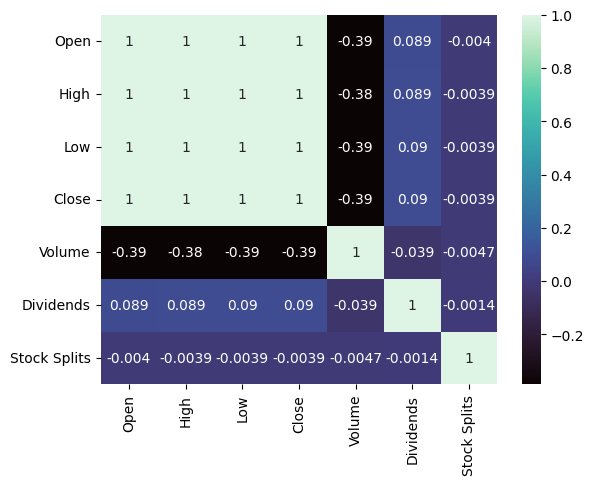

In [12]:
palette = sns.color_palette("mako", as_cmap=True)
corr = data.corr()

sns.heatmap(data=corr,cmap=palette,annot=True)

Existe correlação total entre Open,High,Low e Close

# Análise visual:
* 1. Teste ANOVA
* 2. Análise de tendência: média móvel, regressão, análise de decomposição



## Teste anova

In [13]:
anova1 = f_oneway(data['Close'], data['Volume'], data['Stock Splits'], data['Dividends'])
anova2 = f_oneway(data['Close'], data['Open'], data['High'], data['Low'])

print("Estatística F (Variaveis com alta compatibilidade):", anova2.statistic)
print("Valor p:", anova2.pvalue)

print('\n')
print("Estatística F (Variaveis com baixa compatibilidade):", anova1.statistic)
print("Valor p:", anova1.pvalue)

Estatística F (Variaveis com alta compatibilidade): 0.27372092466418846
Valor p: 0.8443976304546679


Estatística F (Variaveis com baixa compatibilidade): 1898.762362151304
Valor p: 0.0


In [14]:
resultado_anova = []
pares_de_colunas = combinations(data.columns, 2)
for par in pares_de_colunas:
    anova = f_oneway(data[par[0]], data[par[1]])
    resultado_anova.append({'Coluna 1': par[0], 'Coluna 2': par[1], 'Estatística F': anova.statistic, 'Valor p': anova.pvalue})
    
df_resultado = pd.DataFrame(resultado_anova)
df_resultado

,Coluna 1,Coluna 2,Estatística F,Valor p
0,Open,High,0.190523,0.662494
1,Open,Low,0.220484,0.638685
2,Open,Close,0.000034,0.995339
3,Open,Volume,1898.740810,0.000000
4,Open,Dividends,3774.152577,0.000000
5,Open,Stock Splits,3774.125915,0.000000
6,High,Low,0.821065,0.364897
7,High,Close,0.195769,0.658170
8,High,Volume,1898.740483,0.000000
9,High,Dividends,3775.194140,0.000000


## Análise de média móvel

Suavizar a os fechamentos mensais e verificar se há declinio ou aumento

In [15]:
data['mediamovel'] = data['Dividends'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Dividends']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Dividends'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: dividendos',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig.show(renderer='iframe')

In [16]:
data['mediamovel'] = data['Close'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Close']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Fechamento',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig.show(renderer='iframe')

In [17]:
data['mediamovel'] = data['Volume'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Volume']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Volume'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Volume',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig.show(renderer='iframe')

In [18]:
data['mediamovel'] = data['Stock Splits'].rolling(window=30, min_periods=1).mean()

X = np.arange(len(data)).reshape(-1, 1)
y = data['Stock Splits']

model = lr()
model.fit(X, y)
pred = model.predict(X)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Stock Splits'], mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=data.index, y=data['mediamovel'], mode='lines', name='Média móvel'))
fig.add_trace(go.Scatter(x=data.index,y=pred,mode='lines',name='Tendência pela regressão linear'))
fig.update_layout(title='Série Temporal com Média Móvel: Divisão de ações ',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

data = data.drop(columns=['mediamovel'])

fig.show(renderer='iframe')

## Análise de decomposição por adição

Análise de sazonalidade e tendência

In [19]:
new_data = data.copy()
new_data['Date'] = pd.to_datetime(new_data.index)
new_data.set_index('Date', inplace=True)
new_data = new_data.asfreq('ME')
new_data.fillna(new_data.mode().iloc[0], inplace=True)

decomposicao = sm.tsa.seasonal_decompose(pd.DataFrame(new_data['Close']), model='additive')

fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,y=data.Close,mode='lines',name='Original'))
fig.add_trace(go.Scatter(x=decomposicao.trend.index,y=decomposicao.trend.values,mode='lines',name='Tendência'))
fig.add_trace(go.Scatter(x=decomposicao.seasonal.index,y=decomposicao.seasonal.values,mode='lines',name='Sazonalidade'))
fig.add_trace(go.Scatter(x=decomposicao.resid.index,y=decomposicao.resid.values,mode='lines',name='Residuo'))

fig.update_layout(title='Decomposição: Análise de tendência e sazonalidade: Modelo aditivo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

fig.show(renderer='iframe')

In [20]:
new_data = data.copy()
new_data['Date'] = pd.to_datetime(new_data.index)
new_data.set_index('Date', inplace=True)
new_data = new_data.asfreq('ME')
new_data.fillna(new_data.mode().iloc[0], inplace=True)

decomposicao = sm.tsa.seasonal_decompose(pd.DataFrame(new_data['Close']), model='multiplicative')

fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index,y=data.Close,mode='lines',name='Original'))
fig.add_trace(go.Scatter(x=decomposicao.trend.index,y=decomposicao.trend.values,mode='lines',name='Tendência'))
fig.add_trace(go.Scatter(x=decomposicao.seasonal.index,y=decomposicao.seasonal.values,mode='lines',name='Sazonalidade'))
fig.add_trace(go.Scatter(x=decomposicao.resid.index,y=decomposicao.resid.values,mode='lines',name='Residuo'))

fig.update_layout(title='Decomposição: Análise de tendência e sazonalidade: modelo multiplicativo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  hovermode='x')

fig.show(renderer='iframe')


# Machine learning
* Modelos não lineares simples: SVM, Random Forest
* Modelos médios probabilisticos: Cadeias de markov ocultas e ANN

## SSVR (Máquina de suporte de vetores sazonais)
mesmo modelo porém adicionando fatores sazonais, incluindo:
*     dias semana
*     mês
*     feriado



In [21]:
hus = holidays.USA()
slice_ = data.copy()
slice_["OrdinalDate"] = slice_.index.map(pd.Timestamp.toordinal)
slice_["day"] = slice_.index.dayofweek
slice_["isHoliDay"] = slice_.index.isin(hus).astype(int)
slice_["MovingAvg5"] = slice_["Close"].rolling(window=5).mean()
slice_["Volatility10"] = slice_["Close"].rolling(window=10).std()

# Preencher valores ausentes após calcular médias móveis e volatilidade
slice_.fillna(method='bfill', inplace=True)

# Features (X) e target (y)
X = slice_[["OrdinalDate", "day", "isHoliDay", "MovingAvg5", "Volatility10"]].values
y = slice_["Close"].values

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Criando escaladores
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Escalando os dados de treino e teste
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

/tmp/ipykernel_30/2748149639.py:10: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [22]:
model_poly3 = SVR(kernel='poly', degree=3)
model_poly3.fit(X_train,y_train)

model_poly5 = SVR(kernel='poly', degree=5)
model_poly5.fit(X_train,y_train)

model_linear = SVR(kernel="linear", gamma=0.01)
model_linear.fit(X_train,y_train)

model_rbf = SVR(kernel="rbf",degree=3)
model_rbf.fit(X_train,y_train)

SVR()

In [23]:
y_pred3 = model_poly3.predict(X_test)
y_pred5 = model_poly5.predict(X_test)
y_linear_pred = model_linear.predict(X_test)
y_rbf = model_rbf.predict(X_test)

print("Poly 3 Sazo: \nMSE: ",mse(y_pred3,y_test),"\nMAE: ",mae(y_pred3,y_test), "\nMAPE",mape(y_pred3,y_test))
print("Poly 5 Sazo: \nMSE: ",mse(y_pred5,y_test),"\nMAE: ",mae(y_pred5,y_test), "\nMAPE",mape(y_pred5,y_test))
print("Linear: \nMSE: ",mse(y_linear_pred,y_test),"\nMAE: ",mae(y_linear_pred,y_test), "\nMAPE",mape(y_linear_pred,y_test) , '\nRMSE:',sqrt(mse(y_linear_pred,y_test)))
print("RBF: \nMSE: ",mse(y_rbf,y_test),"\nMAE: ",mae(y_rbf,y_test), "\nMAPE",mape(y_rbf,y_test) , '\nRMSE:',sqrt(mse(y_rbf,y_test)))

Poly 3 Sazo: 
MSE:  0.20457978740372454 
MAE:  0.34499323490959494 
MAPE 0.36202066879325595
Poly 5 Sazo: 
MSE:  426.9401806867246 
MAE:  6.183979419819771 
MAPE 0.7475165750570856
Linear: 
MSE:  0.03894781757810453 
MAE:  0.1784138543127909 
MAPE 0.14213281923688226 
RMSE: 0.1973520143755937
RBF: 
MSE:  0.5801853776777323 
MAE:  0.6599856933374894 
MAPE 1.0430462080956195 
RMSE: 0.7616990072710692


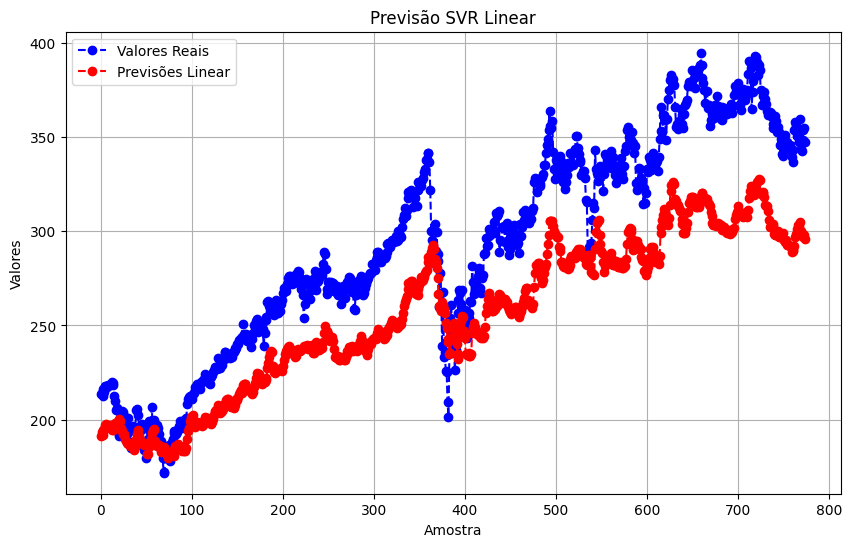

In [24]:
# trace_orig = go.Scatter(
#     x=list(range(len(y_test))),
#     y=y_test,
#     mode='lines',
#     name='Original'
# )

# trace_poly3 = go.Scatter(
#     x=list(range(len(y_test))),
#     y=y_pred3,
#     mode='lines',
#     name='Poly 3'
# )

# trace_poly5 = go.Scatter(
#     x=list(range(len(y_test))),
#     y=y_pred5,
#     mode='lines',
#     name='Poly 5'
# )

# trace_linear = go.Scatter(
#     x=list(range(len(y_test))),
#     y=y_linear_pred,
#     mode='lines',
#     name='Linear'
# )

# layout = go.Layout(
#     title="Comparação entre Previsões SSVR linear e Original - Dados Sazonais",
#     xaxis=dict(title='Index'),
#     yaxis=dict(title='Close Price'),
#     template="plotly_dark"
# )

# fig = go.Figure(data=[trace_orig, trace_linear], layout=layout)

# fig.show(renderer='iframe')

y_pred_rescaled = scaler_y.inverse_transform(y_linear_pred.reshape(-1, 1)).ravel()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_test_rescaled_rbf = scaler_y.inverse_transform(y_rbf.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 6))

# Plotando valores reais e previstos
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label="Valores Reais", color="blue", marker="o", linestyle="dashed")
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label="Previsões Linear", color="red", marker="o", linestyle="dashed")

plt.title("Previsão SVR Linear")
plt.xlabel("Amostra")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

## Gradient Boosting Regressor


In [25]:

xgb_model = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.001,
    max_depth=None,
    random_state=42,
    objective="reg:squarederror",
    subsample=0.8,
    tree_method="hist",
    eval_metric="rmse"
)

# Treinamento do model
xgb_model.fit(X_train, y_train)

# Previsões
y_pred_ = xgb_model.predict(X_test)

# Avaliação do modelo
print("Erro quadrático:", mse(y_test, y_pred_))
print("Erro absoluto:", mae(y_test, y_pred_))
print("MAPE:", mape(y_test,y_pred_))
print("RMSE:", sqrt(mse(y_test, y_pred_)))

# Salvando o modelo em um arquivo pickle
# with open("xgb_model.pkl", "wb") as file:
#     pickle.dump(xgb_model, file)


Erro quadrático: 0.22825983860349391
Erro absoluto: 0.40618392474544657
MAPE: 0.2678452552251359
RMSE: 0.4777654640129338


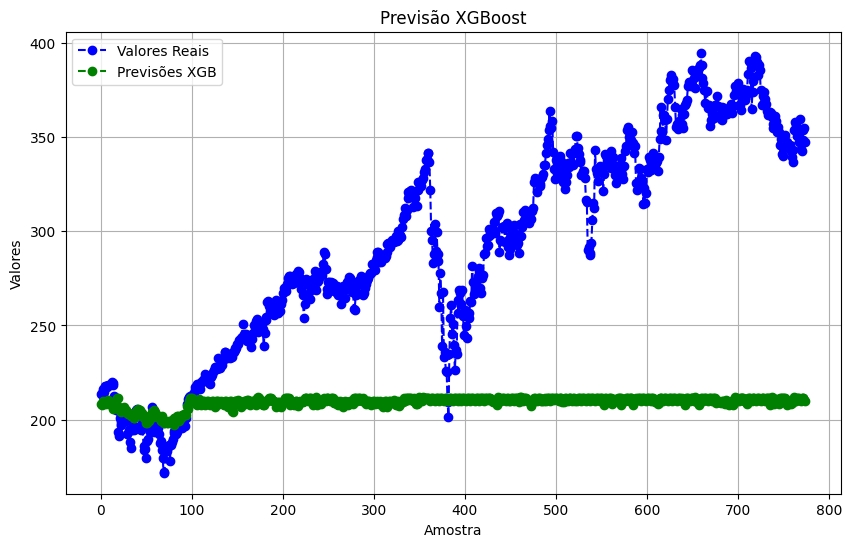

In [26]:
# trace_orig = go.Scatter(
#     x=list(range(len(y_test))),
#     y=y_test,
#     mode='lines',
#     name='Original'
# )

# trace_gbr = go.Scatter(
#     x=list(range(len(y_test))),
#     y=y_pred_,
#     mode='lines',
#     name='Gradient Booster Regressor'
# )

# layout = go.Layout(
#     title="Análise GBR - Dados Sazonais",
#     xaxis=dict(title='Index'),
#     yaxis=dict(title='Close Price'),
#     template="plotly_dark"
# )

# fig = go.Figure(data=[trace_orig, trace_gbr], layout=layout)

# fig.show(renderer='iframe')

# Rescale y_pred para o modelo XGB
y_pred_xgb_rescaled = scaler_y.inverse_transform(y_pred_.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 6))

# Plotando valores reais
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label="Valores Reais", color="blue", marker="o", linestyle="dashed")

# Plotando previsões do modelo XGB
plt.plot(range(len(y_pred_xgb_rescaled)), y_pred_xgb_rescaled, label="Previsões XGB", color="green", marker="o", linestyle="dashed")

# Configuração do plot
plt.title("Previsão XGBoost")
plt.xlabel("Amostra")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()


## ARIMA

Mean Squared Error (MSE): 0.001560128009697354
Mean Absolute Error (MAE): 0.02910446389981522
Root Mean Squared Error (RMSE): 0.039498455788769184
MAPE (Porcentagem de erro absoluto):  0.020939599561119227


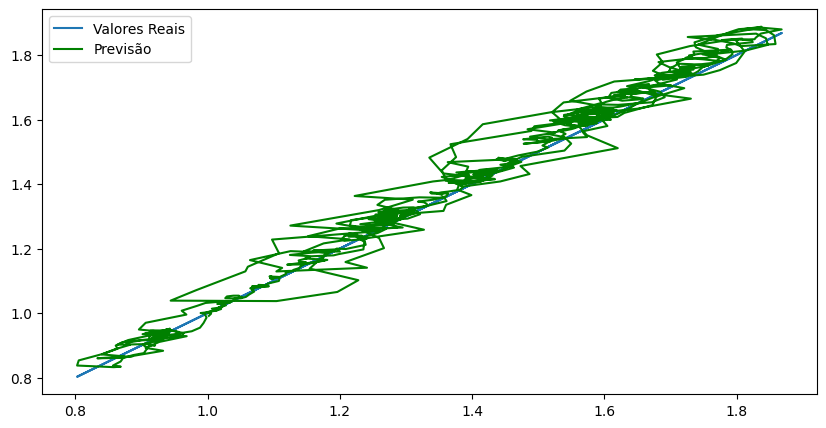

In [27]:

# Ajuste do modelo ARIMAX com os dados de treino
model = ARIMA(y_train, order=(1, 1, 0),exog=X_train)
fitted_model = model.fit(method_kwargs={'maxiter': 500})

# Previsão com os dados de teste
forecast = fitted_model.forecast(steps=len(X_test),exog=X_test)

# Calculando métricas de avaliação
mse_ = mse(y_test, forecast)
mae_ = mae(y_test, forecast)
rmse_ = sqrt(mse(y_test, forecast))
mape_ = mape(y_test,forecast)

print("Mean Squared Error (MSE):", mse_)
print("Mean Absolute Error (MAE):", mae_)
print("Root Mean Squared Error (RMSE):", rmse_)
print("MAPE (Porcentagem de erro absoluto): ",mape_)
# Plot para visualizar a previsão
plt.figure(figsize=(10, 5))
#plt.plot(y_train, label='Treinamento')
plt.plot(y_test, y_test, label='Valores Reais')
plt.plot(y_test, forecast, label='Previsão', color='green')
plt.legend()
plt.show()

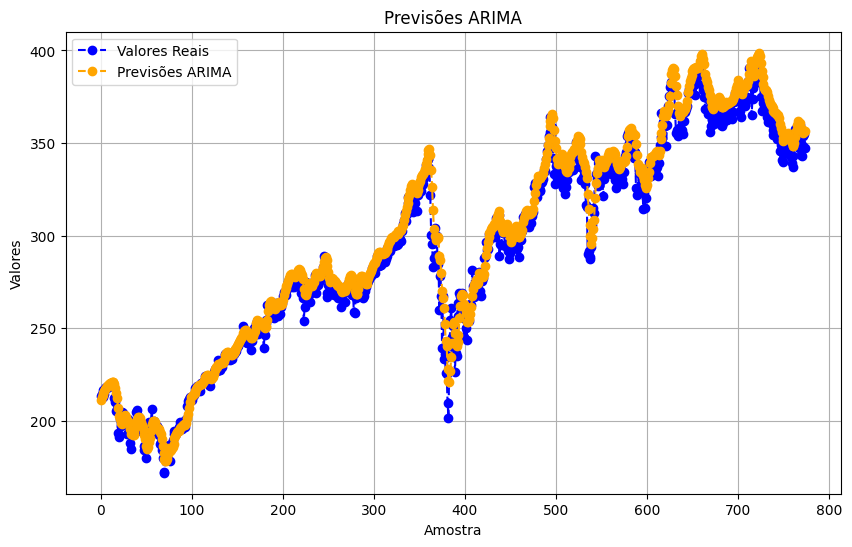

In [28]:
forecast_rescaled = scaler_y.inverse_transform(forecast.reshape(-1, 1)).ravel()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Plotando os valores reais e as previsões do ARIMA
plt.figure(figsize=(10, 6))

plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label="Valores Reais", color="blue", marker="o", linestyle="dashed")
plt.plot(range(len(forecast_rescaled)), forecast_rescaled, label="Previsões ARIMA", color="orange", marker="o", linestyle="dashed")

plt.title("Previsões ARIMA")
plt.xlabel("Amostra")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import plotly.graph_objs as go

trace_orig = go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines',
    name='Original'
)

trace_gbr = go.Scatter(
    x=list(range(len(forecast))),
    y=forecast,
    mode='lines',
    name='ARIMA'
)

layout = go.Layout(
    title="Análise ARIMA - Dados Sazonais",
    xaxis=dict(title='Index'),
    yaxis=dict(title='Close Price'),
    template="plotly_dark"
)

fig = go.Figure(data=[trace_orig, trace_gbr], layout=layout)

fig.show(renderer='iframe')

# LSTM

construção do modelo

## Modelo vanila

In [30]:
class LSTM_1(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTM_1, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, X):
        out, (h_n, _) = self.lstm(X)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = LSTM_1(input_size=X_train_tensor.size(-1), hidden_layer_size=150, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 0.0211
Epoch 2/10, Loss: 0.0138
Epoch 3/10, Loss: 0.0024
Epoch 4/10, Loss: 0.0014
Epoch 5/10, Loss: 0.0010
Epoch 6/10, Loss: 0.0011
Epoch 7/10, Loss: 0.0013
Epoch 8/10, Loss: 0.0008
Epoch 9/10, Loss: 0.0007
Epoch 10/10, Loss: 0.0011


Mean Squared Error (MSE): 0.011582952532406206
Mean Absolute Error (MAE): 0.07852076440579406
Root Mean Squared Error (RMSE): 0.10762412616326418
Mean absolute percent error 0.05895876393322022


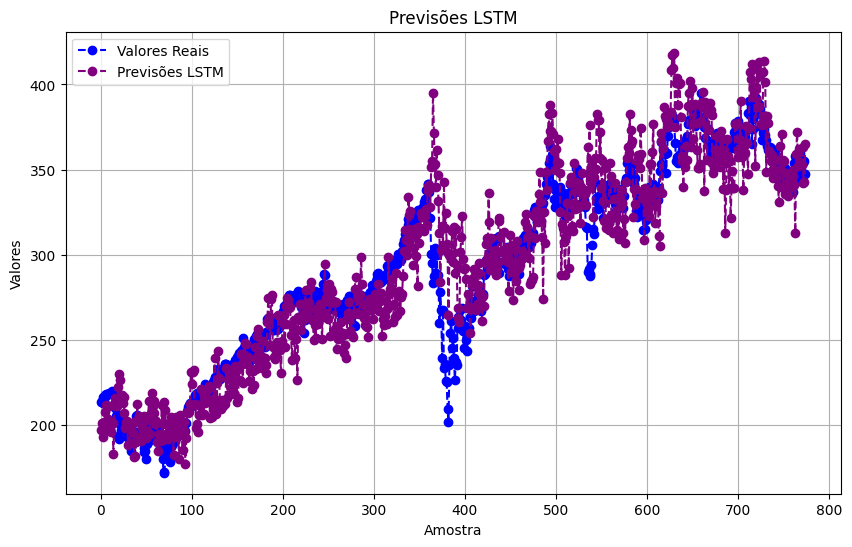

In [31]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)  
predict = model(X_test_tensor)

predict = predict.detach().numpy()

mse_ = mse(y_test, predict)
mae_ = mae(y_test, predict)
rmse_ = sqrt(mse(y_test, predict))
mape_ = mape(y_test,predict)
print("Mean Squared Error (MSE):", mse_)
print("Mean Absolute Error (MAE):", mae_)
print("Root Mean Squared Error (RMSE):", rmse_)
print("Mean absolute percent error", mape_ )


predict_rescaled = scaler_y.inverse_transform(predict.reshape(-1, 1)).ravel()
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Plotando os valores reais e as previsões LSTM
plt.figure(figsize=(10, 6))

plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label="Valores Reais", color="blue", marker="o", linestyle="dashed")
plt.plot(range(len(predict_rescaled)), predict_rescaled, label="Previsões LSTM", color="purple", marker="o", linestyle="dashed")

plt.title("Previsões LSTM")
plt.xlabel("Amostra")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()


#

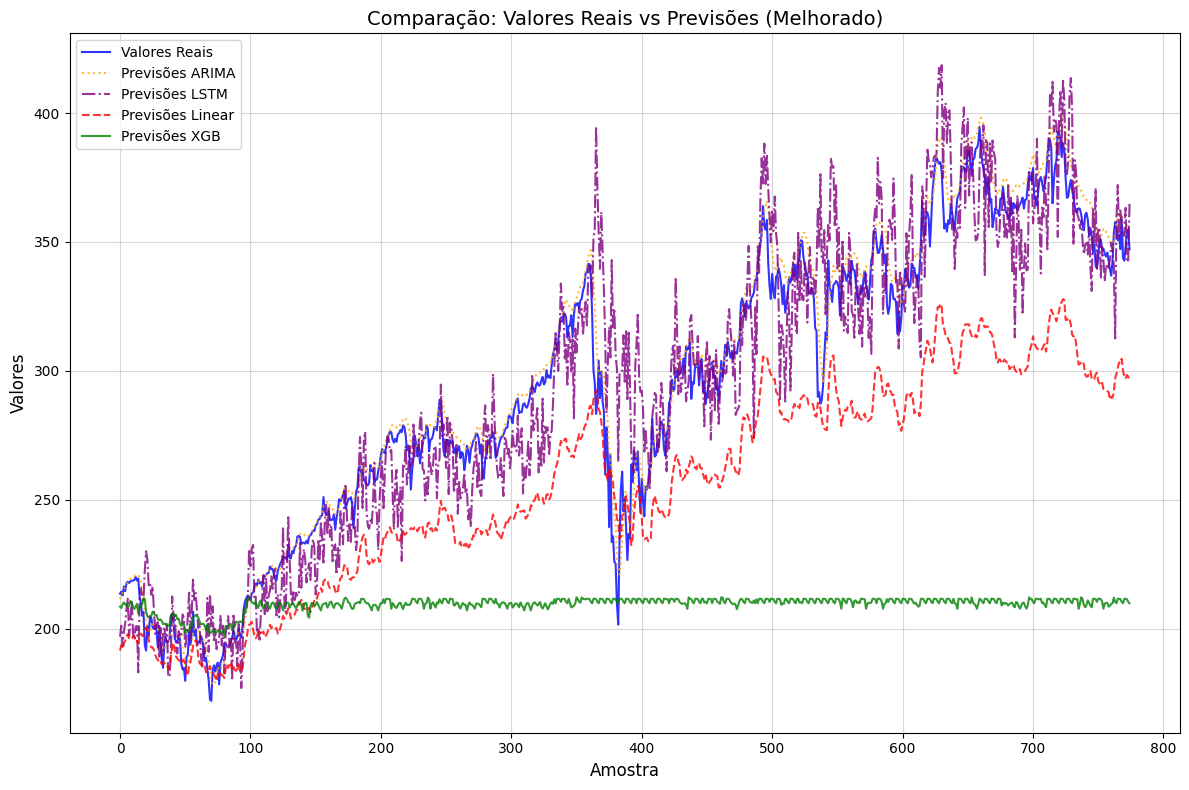

In [32]:
plt.figure(figsize=(12, 8))

# Valores reais
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, label="Valores Reais", color="blue", linestyle="solid", alpha=0.8)

# Previsões ARIMA
plt.plot(range(len(forecast_rescaled)), forecast_rescaled, label="Previsões ARIMA", color="orange", linestyle="dotted", alpha=0.8)

# Previsões LSTM
plt.plot(range(len(predict_rescaled)), predict_rescaled, label="Previsões LSTM", color="purple", linestyle="dashdot", alpha=0.8)

# Previsões Linear
plt.plot(range(len(y_pred_rescaled)), y_pred_rescaled, label="Previsões Linear", color="red", linestyle="dashed", alpha=0.8)

# Previsões XGB
plt.plot(range(len(y_pred_xgb_rescaled)), y_pred_xgb_rescaled, label="Previsões XGB", color="green", linestyle="solid", alpha=0.8)

# Configuração do gráfico
plt.title("Comparação: Valores Reais vs Previsões (Melhorado)", fontsize=14)
plt.xlabel("Amostra", fontsize=12)
plt.ylabel("Valores", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
